## Dataset preparation

In [1]:
import numpy as np
import pandas as pd
from joblib import Parallel, delayed

# ===== Load data; replace with your paths =====
data_dir = './datasets/'
result_dir = './results/'
data_cleaned = pd.read_pickle(data_dir+'data_cleaned.pkl')
descriptors = pd.read_csv(data_dir+'Jarvis_features.csv', index_col=0)

In [2]:
data_l_idx = np.loadtxt(result_dir + 'data_l.csv', dtype='int', delimiter=',')
data_l = data_cleaned.loc[data_l_idx]  # Labeled dataset
data_test_idx = np.loadtxt(result_dir + 'data_test.csv', dtype='int', delimiter=',')
data_test = data_cleaned.loc[data_test_idx]  # Test set
data_u = data_cleaned.drop(index=np.union1d(data_l_idx, data_test_idx), inplace=False)  # Unlabeled dataset

sample_path = np.loadtxt(result_dir + 'sample_path.csv', dtype='int', delimiter=',')
samples = sample_path[sample_path != 0]
samples_rand = data_u.sample(n=samples.shape[0], random_state=42)  # Randomly selected samples

data_l_etal_idx = np.concatenate((data_l_idx, samples)) # Two training sets
data_l_rand = pd.concat([data_l, samples_rand])

In [3]:
# Featurize training and test sets
x_etal= descriptors.loc[data_l_etal_idx]
x_rand = descriptors.loc[data_l_rand.index]
x_test = descriptors.loc[data_test_idx]

# Responses: bulk and shear moduli
B_etal = data_cleaned.loc[data_l_etal_idx]['bulk_modulus_kv']
B_rand = data_cleaned.loc[data_l_rand.index]['bulk_modulus_kv']
B_test = data_cleaned.loc[data_test_idx]['bulk_modulus_kv']

G_etal = data_cleaned.loc[data_l_etal_idx]['shear_modulus_gv']
G_rand = data_cleaned.loc[data_l_rand.index]['shear_modulus_gv']
G_test = data_cleaned.loc[data_test_idx]['shear_modulus_gv']

## SVM
A support vector machine (SVM)-based ML pipeline.

The material feature vector $x$ is first standardized, then reduced dimension by principal component analysis (PCA). The first 7 principal components are taken as the representation and input to an SVM model.

In [4]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

n_rep = 10
def train_svr_etal_B(i):
    svr_etal_B = make_pipeline(StandardScaler(), PCA(n_components=7), SVR(C=10, kernel='rbf'))
    svr_etal_B.fit(x_etal, B_etal)
    return svr_etal_B.score(x_test, B_test)

def train_svr_rand_B(i):
    svr_rand_B = make_pipeline(StandardScaler(), PCA(n_components=7), SVR(C=10, kernel='rbf'))
    svr_rand_B.fit(x_rand, B_rand)
    return svr_rand_B.score(x_test, B_test)

svr_r2_etal_B = Parallel(n_jobs=10)(delayed(train_svr_etal_B)(i) for i in range (n_rep))
svr_r2_rand_B = Parallel(n_jobs=10)(delayed(train_svr_rand_B)(i) for i in range (n_rep))

Grid cross-validation (CV) search for hyperparameter tuning.

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
svr = Pipeline([('scaler', StandardScaler()), ('pca', PCA()), ('svr', SVR())])
parameters = {'svr__kernel':('rbf', 'poly', 'sigmoid'), 'svr__C': [1,5,10], 'pca__n_components': [3,5,7,9]}
clf = GridSearchCV(svr, parameters)
clf.fit(x_etal, B_etal)

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA()), ('svr', SVR())]),
             param_grid={'pca__n_components': [3, 5, 7, 9],
                         'svr__C': [1, 5, 10],
                         'svr__kernel': ('rbf', 'poly', 'sigmoid')})

## AdaBoost
The adaptive boosting model under default settings.

In [6]:
from sklearn.ensemble import AdaBoostRegressor
n_rep = 30
ab_r2_etal_G = np.zeros(n_rep)
ab_r2_rand_G = np.zeros(n_rep)
for i in range(n_rep):
    ab_etal_G = AdaBoostRegressor(random_state=i).fit(x_etal, G_etal)
    ab_rand_G = AdaBoostRegressor(random_state=i).fit(x_rand, G_rand)
    ab_r2_rand_G[i] = ab_rand_G.score(x_test, G_test)
    ab_r2_etal_G[i] = ab_etal_G.score(x_test, G_test)

ab_r2_etal_B = np.zeros(n_rep)
ab_r2_rand_B = np.zeros(n_rep)
for i in range(n_rep):
    ab_etal_B = AdaBoostRegressor(random_state=i).fit(x_etal, B_etal)
    ab_rand_B = AdaBoostRegressor(random_state=i).fit(x_rand, B_rand)
    ab_r2_rand_B[i] = ab_rand_B.score(x_test, B_test)
    ab_r2_etal_B[i] = ab_etal_B.score(x_test, B_test)

## Random Forest
Tune random forest hyperparameters using grid CV search. Effects of `min_samples_leaf` and `min_samples_split` are found to be insignificant.

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
parameters = {'bootstrap': [True, False],
              'max_depth': [30, 100, None],
              'max_features': ['log2', 'sqrt', None],
              'n_estimators': [30, 100, 300],
              'min_samples_leaf': [1, 2, 4],
              'min_samples_split': [2, 5, 10]
             }
rf = RandomForestRegressor()
rf_cv = GridSearchCV(rf, parameters, verbose=3, n_jobs=-1)
# For other dataset/response, Change G to B; rand to etal
rf_cv.fit(x_rand, G_rand)
rf_cv.best_params_


Fitting 5 folds for each of 486 candidates, totalling 2430 fits
[CV 1/5] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=30;, score=0.483 total time=   0.2s
[CV 5/5] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=30;, score=0.615 total time=   0.2s
[CV 3/5] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=30;, score=0.687 total time=   0.2s
[CV 2/5] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=30;, score=0.698 total time=   0.2s
[CV 4/5] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=30;, score=0.593 total time=   0.2s
[CV 5/5] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=30;, score=0.587 total time=   0.2s
[CV 2/5] END bootstrap

{'bootstrap': True,
 'max_depth': 100,
 'max_features': None,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 300}

In [4]:
from sklearn.ensemble import RandomForestRegressor
from joblib import Parallel, delayed
n_rep = 30
rf_r2_etal_G = np.zeros(n_rep)
rf_r2_rand_G = np.zeros(n_rep)
def train_rf_etal_G(i):
    rf_etal_G = RandomForestRegressor(random_state=i, max_depth=30, n_estimators=300).fit(x_etal, G_etal)
    return rf_etal_G.score(x_test, G_test)

def train_rf_rand_G(i):
    rf_rand_G = RandomForestRegressor(random_state=i, max_depth=30, n_estimators=300).fit(x_rand, G_rand)
    return rf_rand_G.score(x_test, G_test)

rf_r2_etal_G = Parallel(n_jobs=10)(delayed(train_rf_etal_G)(i) for i in range (n_rep))
rf_r2_rand_G = Parallel(n_jobs=10)(delayed(train_rf_rand_G)(i) for i in range (n_rep))

In [5]:
rf_r2_etal_B = np.zeros(n_rep)
rf_r2_rand_B = np.zeros(n_rep)

def train_rf_etal_B(i):
    rf_etal_B = RandomForestRegressor(random_state=i, max_depth=100, n_estimators=300).fit(x_etal, B_etal)
    return rf_etal_B.score(x_test, B_test)
    
    
def train_rf_rand_B(i):
    rf_rand_B = RandomForestRegressor(random_state=i, max_depth=100, n_estimators=300).fit(x_rand, B_rand)
    return rf_rand_B.score(x_test, B_test)

rf_r2_etal_B = Parallel(n_jobs=10)(delayed(train_rf_etal_B)(i) for i in range (n_rep))
rf_r2_rand_B = Parallel(n_jobs=10)(delayed(train_rf_rand_B)(i) for i in range (n_rep))

Find most improved samples

In [6]:
from sklearn.ensemble import RandomForestRegressor

rf_etal_B = RandomForestRegressor(random_state=42, max_depth=30, n_estimators=300).fit(x_etal, B_etal)
rf_etal_G = RandomForestRegressor(random_state=42, max_depth=30, n_estimators=300).fit(x_etal, G_etal)
rf_rand_B = RandomForestRegressor(random_state=42, max_depth=100, n_estimators=300).fit(x_rand, B_rand)
rf_rand_G = RandomForestRegressor(random_state=42, max_depth=100, n_estimators=300).fit(x_rand, G_rand)

improv = np.abs(rf_rand_G.predict(x_test) - G_test) - np.abs(rf_etal_G.predict(x_test) - G_test)
rf_G_most_improv = improv.astype('float').nlargest(30).index
rf_G_most_improv

improv = np.abs(rf_rand_B.predict(x_test) - B_test) - np.abs(rf_etal_B.predict(x_test) - B_test)
rf_B_most_improv = improv.astype('float').nlargest(30).index
rf_B_most_improv

Int64Index([23576, 34293, 34426, 46765, 23728, 14748, 30965, 28127, 43441,
            25633, 46717, 24436, 27800, 40668,  3023, 21453, 29501, 13041,
            27465, 29923, 13812,  2475, 53852, 22363, 26727, 28088, 29809,
            29654, 35229, 24291],
           dtype='int64')

## Gradient Boost
Tune gradient boost hyperparameters using grid CV search. Again, effects of `min_samples_leaf` and `min_samples_split` are found to be insignificant.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
parameters = {'learning_rate': [0.03, 0.1, 0.3],
              'max_depth': [3, 5, 10, None],
              'max_features': ['log2', 'sqrt', None],
              'n_estimators': [30, 100, 300],
              'min_samples_leaf': [1, 2, 4],
              'min_samples_split': [2, 3, 5]
             }
gb = GradientBoostingRegressor()
gb_cv = GridSearchCV(gb, parameters, verbose=3, n_jobs=-1)
gb_cv.fit(x_etal, B_etal)
gb_cv.best_params_


In [6]:
from sklearn.ensemble import GradientBoostingRegressor
n_rep = 30

def train_gb_etal_G(i):
    gb_etal_G = GradientBoostingRegressor(random_state=i, max_depth=5).fit(x_etal, G_etal)
    return gb_etal_G.score(x_test, G_test)

def train_gb_rand_G(i):
    gb_rand_G = GradientBoostingRegressor(random_state=i, max_depth=5).fit(x_rand, G_rand)
    return gb_rand_G.score(x_test, G_test)

gb_r2_etal_G = Parallel(n_jobs=10)(delayed(train_gb_etal_G)(i) for i in range (n_rep))
gb_r2_rand_G = Parallel(n_jobs=10)(delayed(train_gb_rand_G)(i) for i in range (n_rep))


In [7]:
def train_gb_etal_B(i):
    gb_etal_B = GradientBoostingRegressor(random_state=i, max_depth=5).fit(x_etal, B_etal)
    return gb_etal_B.score(x_test, B_test)

def train_gb_rand_B(i):
    gb_rand_B = GradientBoostingRegressor(random_state=i, max_depth=5).fit(x_rand, B_rand)
    return gb_rand_B.score(x_test, B_test)

gb_r2_etal_B = Parallel(n_jobs=10)(delayed(train_gb_etal_B)(i) for i in range (n_rep))
gb_r2_rand_B = Parallel(n_jobs=10)(delayed(train_gb_rand_B)(i) for i in range (n_rep))

Find most improved samples

In [5]:
from sklearn.ensemble import GradientBoostingRegressor

gb_etal_B = GradientBoostingRegressor(random_state=42, max_depth=5).fit(x_etal, B_etal)
gb_etal_G = GradientBoostingRegressor(random_state=42, max_depth=5).fit(x_etal, G_etal)
gb_rand_B = GradientBoostingRegressor(random_state=42, max_depth=5).fit(x_rand, B_rand)
gb_rand_G = GradientBoostingRegressor(random_state=42, max_depth=5).fit(x_rand, G_rand)


improv = np.abs(gb_rand_B.predict(x_test) - B_test) - np.abs(gb_etal_B.predict(x_test) - B_test)
gb_B_most_improv = improv.astype('float').nlargest(30).index
gb_B_most_improv

improv = np.abs(gb_rand_G.predict(x_test) - G_test) - np.abs(gb_etal_G.predict(x_test) - G_test)
gb_G_most_improv = improv.astype('float').nlargest(30).index
gb_G_most_improv

Int64Index([34293, 34426, 46765, 23728, 35229, 24788,  1356, 20658, 28127,
             2298, 34920, 17127, 30202, 21761, 14011, 14761, 46717, 50280,
            30965, 24436, 33577, 13812, 17550,  2794, 41233,  6712, 35786,
             9568, 24469, 44087],
           dtype='int64')

## Neural Net
A multi-layer perceptron (MLP) model with standardized materials features as input. Hyperparameters are tuned using Grid CV search.

In [13]:
from sklearn.neural_network import MLPRegressor
from joblib import Parallel, delayed
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
n_rep = 30
hidden_size = (128,)
batch_size = 32
max_iter = 500
alpha = 0.1
# learning_rate_init = 0.001
activation = 'relu'

def train_nn_etal_B(i):
    nn_etal_B = make_pipeline(StandardScaler(), MLPRegressor(hidden_layer_sizes=hidden_size, random_state=i, early_stopping=True, alpha=alpha, batch_size=batch_size,
    max_iter=max_iter, activation=activation))
    nn_etal_B.fit(x_etal, B_etal)
    return nn_etal_B.score(x_test, B_test)

def train_nn_rand_B(i):
    nn_rand_B = make_pipeline(StandardScaler(), MLPRegressor(hidden_layer_sizes=hidden_size, random_state=i, early_stopping=True, alpha=alpha, batch_size=batch_size,
    max_iter=max_iter, activation=activation))
    nn_rand_B.fit(x_rand, B_rand)
    return nn_rand_B.score(x_test, B_test)

nn_r2_etal_B = Parallel(n_jobs=10)(delayed(train_nn_etal_B)(i) for i in range (n_rep))
nn_r2_rand_B = Parallel(n_jobs=10)(delayed(train_nn_rand_B)(i) for i in range (n_rep))


def train_nn_etal_G(i):
    nn_etal_G = make_pipeline(StandardScaler(), MLPRegressor(hidden_layer_sizes=hidden_size, random_state=i, early_stopping=True, alpha=alpha, batch_size=batch_size,
    max_iter=max_iter, activation=activation))
    nn_etal_G.fit(x_etal, G_etal)
    return nn_etal_G.score(x_test, G_test)

def train_nn_rand_G(i):
    nn_rand_G = make_pipeline(StandardScaler(), MLPRegressor(hidden_layer_sizes=hidden_size, random_state=i, early_stopping=True, alpha=alpha, batch_size=batch_size,
    max_iter=max_iter, activation=activation))
    nn_rand_G.fit(x_rand, G_rand)
    return nn_rand_G.score(x_test, G_test)

nn_r2_etal_G = Parallel(n_jobs=10)(delayed(train_nn_etal_G)(i) for i in range (n_rep))
nn_r2_rand_G = Parallel(n_jobs=10)(delayed(train_nn_rand_G)(i) for i in range (n_rep))

Grid CV search for NN hyperparameter tuning.

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
nn = Pipeline([('scaler', StandardScaler()), ('mlp', MLPRegressor(early_stopping=True, max_iter=500, batch_size=32))])
parameters = {'mlp__alpha': [0.01, 0.05, 0.1],
              'mlp__activation': ('tanh', 'relu'),
              'mlp__hidden_layer_sizes': ((128,), (64,64), (128,128))
             }
clf = GridSearchCV(nn, parameters, verbose=3, n_jobs=-1)
clf.fit(x_etal, B_etal)
clf.best_params_

Fitting 5 folds for each of 18 candidates, totalling 90 fits


{'mlp__activation': 'tanh',
 'mlp__alpha': 0.1,
 'mlp__hidden_layer_sizes': (128,)}

## Save results

In [8]:
results = pd.concat([pd.DataFrame({'r2': gb_r2_etal_B, 'model': 'gb-B', 'target': 'B', 'dataset':'etal'}),
                     pd.DataFrame({'r2': gb_r2_etal_G, 'model': 'gb-G', 'target': 'G', 'dataset':'etal'}),
                     pd.DataFrame({'r2': rf_r2_etal_B, 'model': 'rf-B', 'target': 'B', 'dataset':'etal'}),
                     pd.DataFrame({'r2': rf_r2_etal_G, 'model': 'rf-G', 'target': 'G', 'dataset':'etal'}),
                     pd.DataFrame({'r2': gb_r2_rand_B, 'model': 'gb-B', 'target': 'B', 'dataset':'rand'}),
                     pd.DataFrame({'r2': gb_r2_rand_G, 'model': 'gb-G', 'target': 'G', 'dataset':'rand'}),
                     pd.DataFrame({'r2': rf_r2_rand_B, 'model': 'rf-B', 'target': 'B', 'dataset':'rand'}),
                     pd.DataFrame({'r2': rf_r2_rand_G, 'model': 'rf-G', 'target': 'G', 'dataset':'rand'}),
                    ], ignore_index=True)
results.to_csv('./results/ML_r2.csv')

In [18]:
results

,Unnamed: 0,r2,model,target,dataset
0,0,0.840443,Gradient Boosting,B,ETAL
1,1,0.840648,Gradient Boosting,B,ETAL
2,2,0.840260,Gradient Boosting,B,ETAL
3,3,0.840529,Gradient Boosting,B,ETAL
4,4,0.840100,Gradient Boosting,B,ETAL
...,...,...,...,...,...
235,235,0.745212,Random Forest,G,RAND
236,236,0.745729,Random Forest,G,RAND
237,237,0.745608,Random Forest,G,RAND
238,238,0.747684,Random Forest,G,RAND


## Make plot

In [17]:
results

,Unnamed: 0,r2,model,target,dataset
0,0,0.840443,Gradient Boosting,B,ETAL
1,1,0.840648,Gradient Boosting,B,ETAL
2,2,0.840260,Gradient Boosting,B,ETAL
3,3,0.840529,Gradient Boosting,B,ETAL
4,4,0.840100,Gradient Boosting,B,ETAL
...,...,...,...,...,...
235,235,0.745212,Random Forest,G,RAND
236,236,0.745729,Random Forest,G,RAND
237,237,0.745608,Random Forest,G,RAND
238,238,0.747684,Random Forest,G,RAND


In [19]:
results = pd.read_csv('./results/ML_r2.csv', index_col=0)
results.loc[results['model'] == 'gb-B', 'model'] = 'Gradient Boosting'
results.loc[results['model'] == 'gb-G', 'model'] = 'Gradient Boosting'
results.loc[results['model'] == 'rf-B', 'model'] = 'Random Forest'
results.loc[results['model'] == 'rf-G', 'model'] = 'Random Forest'
results.loc[results['dataset'] == 'etal', 'dataset'] = 'ETAL'
results.loc[results['dataset'] == 'rand', 'dataset'] = 'RAND'
results.columns = ['r2', 'Model', 'Target', 'Dataset']

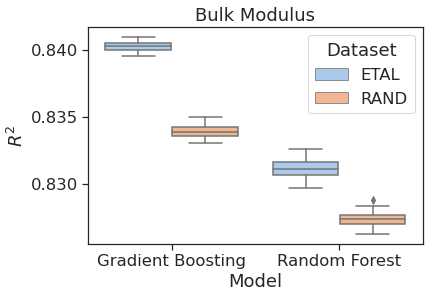

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
# results = pd.read_csv('./results/ML_r2.csv', index_col=0)
sns.set_theme(style="ticks", palette='pastel', font_scale=1.5)
sns.boxplot(x='Model', y='r2', hue='Dataset', data=results[(results['Target'] == 'B')])
plt.ylabel('$R^2$')
plt.title('Bulk Modulus')
# plt.savefig('./results/r2_B.svg', bbox_inches='tight')
plt.savefig('./results/r2_B.png', dpi=300, bbox_inches='tight')

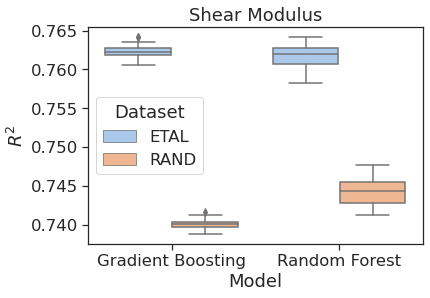

In [24]:
sns.set_theme(style="ticks", palette='pastel', font_scale=1.5)
sns.boxplot(x='Model', y='r2', hue='Dataset', data=results[(results['Target'] == 'G')])
plt.ylabel('$R^2$')
plt.title('Shear Modulus')
# plt.savefig('./results/r2_G.svg', bbox_inches='tight')
plt.savefig('./results/r2_G.png', dpi=300, bbox_inches='tight')